In [1]:
!pip install -Uqq fastai

In [2]:
!ls

sample_data


In [5]:
from fastcore.all import *
import time
import json

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')    
    headers = dict( referer='https://duckduckgo.com/' )
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        res = urlread(requestUrl, data=params, headers=headers)
        data = json.loads(res) if res else {}
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [38]:
urls = search_images('diagrams', max_images=3)
urls[0]

'http://www.conceptdraw.com/solution-park/resource/images/solutions/target-and-circular-diagrams/Target-Circular-Diagrams-Solution-mac.png'

In [9]:
!pip install fastdownload

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


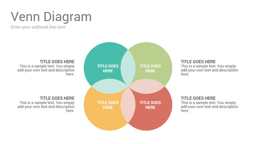

In [39]:
from fastdownload import download_url
dest = 'diagrams.jpg'
download_url(urls[2], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

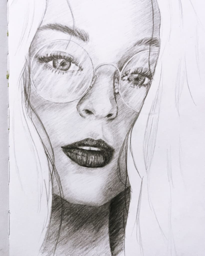

In [37]:
download_url(search_images('sketches', max_images=3)[2], 'sketch.jpg', show_progress=False)
Image.open('sketch.jpg',).to_thumb(256,256)

In [13]:
sea = 'sketches', 'diagrams'
path= Path('diagram_or_not')

for o in sea:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photo'))
  resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:1015: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

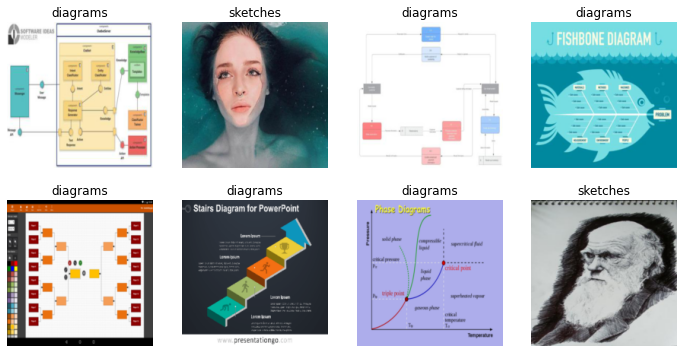

In [15]:
dls= DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items= get_image_files,
    splitter= RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms= [Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=8)

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.021607,0.192143,0.080000,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.271181,0.088484,0.026667,00:43
1,0.158030,0.090115,0.013333,00:43
2,0.114552,0.085539,0.013333,00:39


In [45]:
is_diag,_,probs= learn.predict(Image.open('diagrams.jpg').to_thumb(256,256))
print(f'This is a {is_diag}')
print(f'probability it is a diagram = {probs[0]:.4f}')

This is a diagrams
probability it is a bird = 1.0000


In [ ]:
is_sketch,_,probs= learn.predict(PILImage.create('sketch.jpg'))
print(f'This is a {is_sketch})')
print(f'probability it is a bird = {probs[1]:.4f}')